<a href="https://colab.research.google.com/github/muditha11/Deep-Learning/blob/main/02_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Making Dataset

In [ ]:
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.datasets import make_circles

n_samples=1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

In [ ]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of Y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y:
 [1 1 1 1 0]


In [ ]:
circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


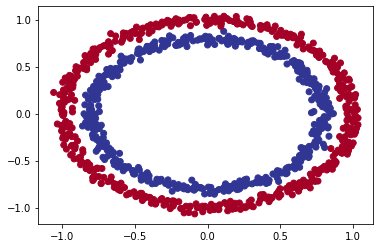

In [ ]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

We want to predict whether a point is on red circle or blue circle

In [ ]:
## input and output shapes
X.shape,y.shape

((1000, 2), (1000,))

In [ ]:
X_sample = X[0]
y_sample = y[0]

print(X_sample,y_sample)
print(X_sample.shape,y_sample.shape)

[0.75424625 0.23148074] 1
(2,) ()


In [ ]:
## Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]), tensor([1., 1., 1., 1., 0.]))

In [ ]:
torch.manual_seed(42)

In [ ]:
#Train-Test split
X_train,X_test,y_train,y_test = train_test_split(X,
                                                 y,
                                                 train_size=.8,
                                                 random_state=42)

## Build Model

### Device agnostic code

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Creating Model

In [ ]:
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features = 2, out_features = 5) #take in 2 features and upscale to 5
    self.layer2 = nn.Linear(in_features = 5, out_features = 1) 

    # self.two_linear_layers = nn.Sequential(
    #                               nn.Linear(in_features=2,out_features=5),
    #                               nn.Linear(in_features=5,out_features=1)
    #                           )

  def forward(self,x):
    return self.layer2(self.layer1(x))
    # return two_linear_layers(x)


In [ ]:
# ### Using nn.Sequential to replicate above model

# model0 = nn.Sequential(
#     nn.Linear(in_features=2,out_features=5),
#     nn.Linear(in_features=5,out_features=1)
# ).to(device)

# model0

In [ ]:
model0 = CircleModel().to(device)
model0

CircleModel(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
model0.state_dict()

OrderedDict([('layer1.weight', tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer2.bias', tensor([-0.2060], device='cuda:0'))])

### Loss function and optimizer

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model0.parameters(),lr=0.1)

In [ ]:
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

### Training model

#### Understanding data formats


Before we go to the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [ ]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]

y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], device='cuda:0')

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the sigmoid activation function.



In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], device='cuda:0')

In [ ]:
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [ ]:
y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0')

Now it looks like our model's predictions are in the same form as our truth labels (y_test).

In [ ]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

#### Training Loop

In [ ]:
epochs = 100

X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test = X_test.to(device),y_test.to(device)

for epoch in range(epochs):
  model0.train()
  #forward pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #Calc loss
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  #optimizer
  optimizer.zero_grad()

  #loss back
  loss.backward()

  #optimizer step
  optimizer.step()

  #############Testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,y_test)
    test_acc = accuracy_fn(y_true=y_test,y_pred=test_pred)

  if(epoch%10==0):
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69569, Accuracy: 50.00% | Test loss: 0.69721, Test acc: 50.00%
Epoch: 10 | Loss: 0.69403, Accuracy: 50.00% | Test loss: 0.69615, Test acc: 50.00%
Epoch: 20 | Loss: 0.69343, Accuracy: 46.00% | Test loss: 0.69585, Test acc: 48.50%
Epoch: 30 | Loss: 0.69321, Accuracy: 49.00% | Test loss: 0.69577, Test acc: 47.50%
Epoch: 40 | Loss: 0.69312, Accuracy: 49.50% | Test loss: 0.69573, Test acc: 46.50%
Epoch: 50 | Loss: 0.69308, Accuracy: 50.38% | Test loss: 0.69569, Test acc: 46.50%
Epoch: 60 | Loss: 0.69306, Accuracy: 50.50% | Test loss: 0.69564, Test acc: 46.50%
Epoch: 70 | Loss: 0.69305, Accuracy: 50.50% | Test loss: 0.69559, Test acc: 46.50%
Epoch: 80 | Loss: 0.69304, Accuracy: 50.75% | Test loss: 0.69553, Test acc: 46.50%
Epoch: 90 | Loss: 0.69303, Accuracy: 50.38% | Test loss: 0.69547, Test acc: 46.50%


In [ ]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

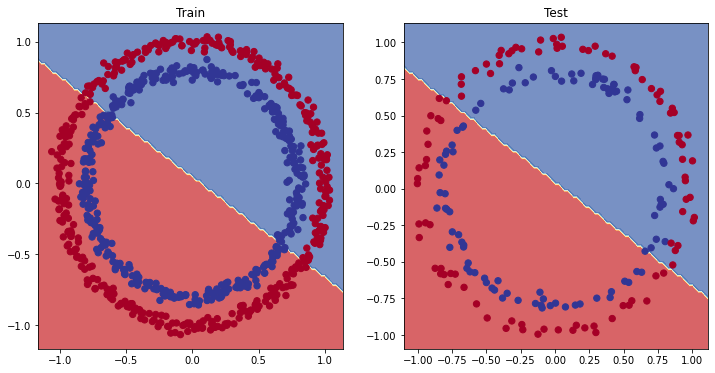

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

#### Improving a model

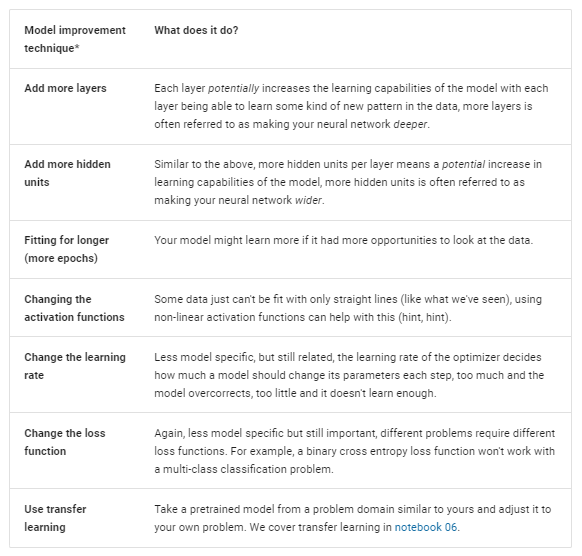

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

model is still drawing a straight line between the red and blue dots.



The missing piece: non-linearity

### non-linearity

#### data

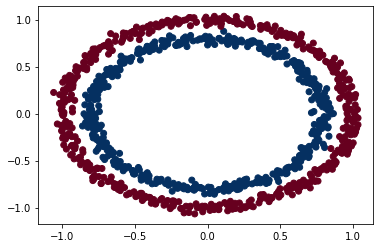

In [ ]:
n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]), tensor([1., 0., 0., 0., 1.]))

#### Non linear model

In [ ]:
class CircleModelv1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model3 = CircleModelv1().to(device)
print(model3)

CircleModelv1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


#### loss function

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

#### Training loop

In [ ]:
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 100 | Loss: 0.48153, Accuracy: 93.50% | Test Loss: 0.49935, Test Accuracy: 90.50%
Epoch: 200 | Loss: 0.37056, Accuracy: 97.75% | Test Loss: 0.40595, Test Accuracy: 92.00%
Epoch: 300 | Loss: 0.25458, Accuracy: 99.00% | Test Loss: 0.30333, Test Accuracy: 96.50%
Epoch: 400 | Loss: 0.17180, Accuracy: 99.50% | Test Loss: 0.22108, Test Accuracy: 97.50%
Epoch: 500 | Loss: 0.12188, Accuracy: 99.62% | Test Loss: 0.16512, Test Accuracy: 99.00%
Epoch: 600 | Loss: 0.09123, Accuracy: 99.88% | Test Loss: 0.12741, Test Accuracy: 99.50%
Epoch: 700 | Loss: 0.07100, Accuracy: 99.88% | Test Loss: 0.10319, Test Accuracy: 99.50%
Epoch: 800 | Loss: 0.05773, Accuracy: 99.88% | Test Loss: 0.08672, Test Accuracy: 99.50%
Epoch: 900 | Loss: 0.04853, Accuracy: 99.88% | Test Loss: 0.07474, Test Accuracy: 99.50%


In [ ]:
model3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

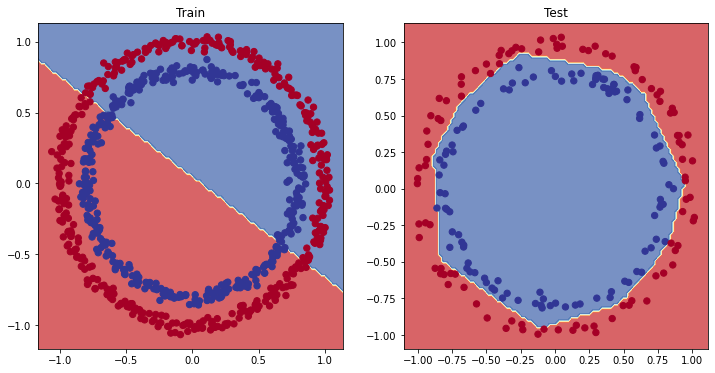

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test) # model_3 = has non-linearity

## Multi Class Classification

### Load data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


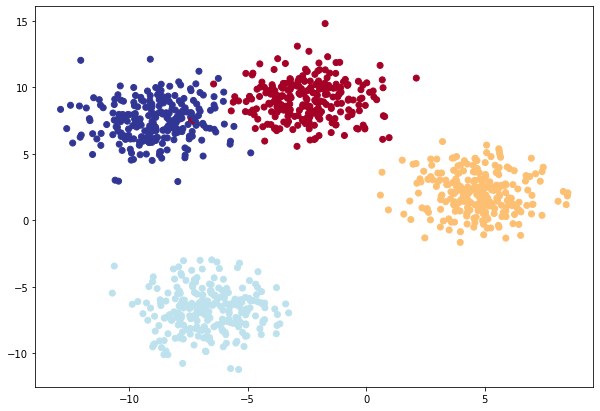

In [ ]:
from sklearn.datasets import make_blobs

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### Build Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
X_blob_train[0]

tensor([5.0405, 3.3076])

In [ ]:
model_4(X_blob_train.to(device))

tensor([[ 0.3316, -0.3946, -0.2512,  0.1329],
        [ 0.1992, -0.8168, -0.4006,  0.2831],
        [-0.7704, -1.5378, -0.7110,  0.3993],
        ...,
        [ 0.2050, -0.8204, -0.3998,  0.3071],
        [-0.5316, -1.2671, -0.6085,  0.2994],
        [ 0.1208, -0.6211, -0.3263, -0.0825]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### Loss Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1)

### Understanding Output type

In [ ]:
next(model_4.parameters()).device

device(type='cuda', index=0)

In [ ]:
X_blob_test.device

device(type='cpu')

Both model and data should be in same device

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[ 0.0526, -0.2045, -0.2092,  0.2132],
        [-1.1945, -0.0860, -0.2828,  2.0576],
        [-0.2517,  0.7651,  0.4150,  0.5261],
        [-0.0698,  0.0700, -0.2010,  0.2079],
        [-0.5843, -0.7603, -0.5927,  1.2536],
        [-1.4170, -0.0724, -0.2684,  2.4087],
        [-0.2609,  0.7159,  0.4207,  0.2801],
        [-0.7168, -0.6345, -0.5773,  1.4141],
        [-0.3004,  0.9697,  0.6022,  0.9499],
        [-0.6571, -0.6664, -0.5764,  1.3343]], device='cuda:0')

Each row is the output per test (known as logits)

There are 4 values because our output feature number is 4

Inorder to evaluate our model we need to convert logits to prediction probabilities and then to prediction labels

logits-->pred probs-->pred labels

In [ ]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

So model output format and test outputs are in different formats

We need to get them to same format

#### Converting  logits-->pred probs-->pred labels

In [ ]:
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0526, -0.2045, -0.2092,  0.2132],
        [-1.1945, -0.0860, -0.2828,  2.0576],
        [-0.2517,  0.7651,  0.4150,  0.5261],
        [-0.0698,  0.0700, -0.2010,  0.2079],
        [-0.5843, -0.7603, -0.5927,  1.2536]], device='cuda:0')
tensor([[0.2690, 0.2080, 0.2071, 0.3159],
        [0.0309, 0.0936, 0.0769, 0.7986],
        [0.1268, 0.3504, 0.2469, 0.2759],
        [0.2300, 0.2645, 0.2017, 0.3037],
        [0.1097, 0.0920, 0.1088, 0.6894]], device='cuda:0')


In [ ]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [ ]:
torch.max(y_pred_probs[0])

tensor(0.3159, device='cuda:0')

In [ ]:
#index of maximum probability
torch.argmax(y_pred_probs[0])

tensor(3, device='cuda:0')

In [ ]:
#Converting pred_probs to labels
y_preds = torch.argmax(y_pred_probs,dim=1)
y_preds

tensor([3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
        1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3,
        1, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
        1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 3, 3, 1, 3,
        1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3,
        3, 3, 1, 3, 3, 3, 1, 3], device='cuda:0')

In [ ]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

Now both model output and test outputs are in same format

### Train and test loop


In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred = y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step() 

  ### Testing
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred = test_preds)
    
  if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.92702, Acc: 84.00% | Test Loss: 0.81000, Test Acc: 87.50%
Epoch: 10 | Loss: 0.45775, Acc: 96.62% | Test Loss: 0.39471, Test Acc: 98.50%
Epoch: 20 | Loss: 0.29009, Acc: 96.62% | Test Loss: 0.23484, Test Acc: 98.00%
Epoch: 30 | Loss: 0.13811, Acc: 99.12% | Test Loss: 0.11291, Test Acc: 99.00%
Epoch: 40 | Loss: 0.08109, Acc: 99.12% | Test Loss: 0.06747, Test Acc: 99.50%
Epoch: 50 | Loss: 0.05913, Acc: 99.12% | Test Loss: 0.04865, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04863, Acc: 99.25% | Test Loss: 0.03912, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04270, Acc: 99.25% | Test Loss: 0.03349, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03894, Acc: 99.25% | Test Loss: 0.02980, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03637, Acc: 99.25% | Test Loss: 0.02719, Test Acc: 99.50%


In [ ]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.5%


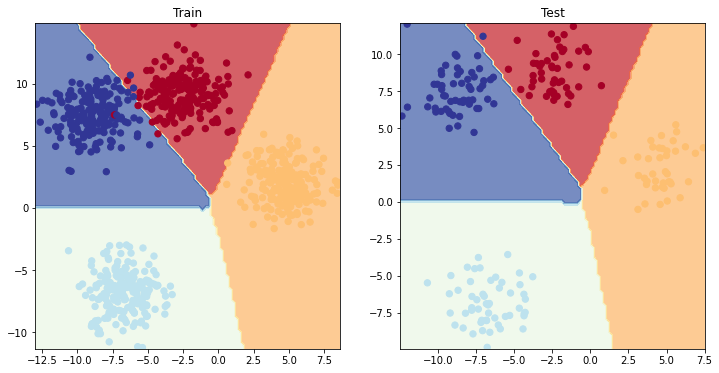

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)